In [1]:
import os
import sys
import time
import warnings
from random import shuffle

import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from tensorflow.python.lib.io import file_io
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from scipy.stats import kurtosis, skew
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
from keras.layers import Conv2DTranspose, Dropout, Activation, BatchNormalization, UpSampling2D, Concatenate
from keras.layers import Input, Conv1D, MaxPooling1D, concatenate, TimeDistributed, Flatten, LSTM, Dense, GlobalAveragePooling1D
from keras.models import Model

In [3]:
# Window Length.
n = 100
STRIDE = 50

In [4]:
def getFeatures(data, fs):
    f1 = np.mean(data, axis=0)
    C = np.cov(data.T)
    f2 = np.concatenate((C[0, 0:3], C[1, 1:3], C[2, 2:3]))
    f3 = np.array([skew(data.iloc[:, 0]), skew(data.iloc[:, 1]), skew(data.iloc[:, 2])])
    f4 = np.array([kurtosis(data.iloc[:, 0]), kurtosis(data.iloc[:, 1]), kurtosis(data.iloc[:, 2])])
    f5 = np.zeros(3)
    f6 = np.zeros(3)
    for i in range(0,3):
        g = abs(np.fft.fft(data.iloc[:,i]))
        g = g[0:round(len(g)/2)]
        g[0] = 0
        max_i = np.argmax(g)
        f5[i] = g[max_i]
        f6[i] = fs * max_i
    return np.concatenate((f1, f2, f3, f4, f5, f6))

In [5]:
def generate_features(df, stride=STRIDE):
    df_out = pd.DataFrame(columns=[i for i in range(0, 42)])
    fs = 1 / n
    i = 0
    for i in range(0, df.shape[0] - n, stride):
        features_accel = getFeatures(df.iloc[i:i+n, 0:3], fs)
        features_gyro = getFeatures(df.iloc[i:i+n, 3:6], fs)
        features = np.concatenate((features_accel, features_gyro))
        df_out.loc[i] = features
        i += 1
    return df_out

In [6]:
# Choose via MODE ## TBD ##
def get_detection_window(df, stride=STRIDE):
    df_out = pd.DataFrame(columns=[0])
    i = 0
    for i in range(0, df.shape[0] - n, stride):
        df_slice = df.iloc[i:i+n,:]
        df_out.loc[i] = df_slice.mode().iloc[0,0]
#         df_out.loc[i] = df.iloc[i+n-1]
        i += 1
    return df_out

In [7]:
def extrapolate_predictions(predictions, size):
    extrapolated = np.fromiter((val for val in predictions for _ in range(0, STRIDE)), float)
    return extrapolated[0:size]

In [8]:
# Initializing dataframes for training and validation.
x_train = pd.DataFrame(columns=[i for i in range(0, 12)])
y_train = pd.DataFrame(columns=[0])
x_val = pd.DataFrame(columns=[i for i in range(0, 12)])
y_val = pd.DataFrame(columns=[0])

train_sessions = ['Session01', 'Session05', 'Session06', 'Session07', 'Session12']
# sessions = ['Session01_tmp']
count = 0
count_res = 0
for session in train_sessions:
    print('Processing training {}'.format(session))
    df_data_arm = pd.read_csv('TrainingData/{}/armIMU.txt'.format(session),  delim_whitespace=True, header=None)
    arm_features = generate_features(df_data_arm)
    df_data_wrist = pd.read_csv('TrainingData/{}/wristIMU.txt'.format(session), delim_whitespace=True, header=None)
    wrist_features = generate_features(df_data_wrist)
    count += df_data_arm.shape[0]
    features = pd.concat([arm_features, wrist_features], axis=1, sort=False, ignore_index=True)
    count_res += features.shape[0]
    df_data_detection = pd.read_csv('TrainingData/{}/detection.txt'.format(session), header=None)
    x_train = x_train.append(other=features, ignore_index=True)
    y_train = y_train.append(other=get_detection_window(df_data_detection), ignore_index=True)
print(count)
print(count_res)
x_train.to_csv('x_train.txt', header=False, index=False, sep='\t')
y_train.to_csv('y_train.txt', header=False, index=False, sep='\t')
print('Saved training features!')
    
val_sessions = ['Session13']
for session in val_sessions:
    df_data_arm = pd.read_csv('TrainingData/{}/armIMU.txt'.format(session),  delim_whitespace=True, header=None)
    arm_features = generate_features(df_data_arm)
    df_data_wrist = pd.read_csv('TrainingData/{}/wristIMU.txt'.format(session), delim_whitespace=True, header=None)
    wrist_features = generate_features(df_data_wrist)
    count += df_data_arm.shape[0]
    features = pd.concat([arm_features, wrist_features], axis=1, sort=False, ignore_index=True)
    count_res += features.shape[0]
    df_data_detection = pd.read_csv('TrainingData/{}/detection.txt'.format(session), header=None)
    x_val = x_val.append(other=features, ignore_index=True)
    y_val = y_val.append(other=get_detection_window(df_data_detection), ignore_index=True)
    
x_val.to_csv('x_val.txt', header=False, index=False, sep='\t')
y_val.to_csv('y_val.txt', header=False, index=False, sep='\t')
print('Saved validation features!')

Processing training Session01
Processing training Session05
Processing training Session06
Processing training Session07
Processing training Session12
906113
18115
Saved training features!
Saved validation features!


In [9]:
x_train_df = np.loadtxt('x_train.txt', delimiter='\t')
y_train_df = np.loadtxt('y_train.txt', delimiter='\t')
x_val_df = np.loadtxt('x_val.txt', delimiter='\t')
y_val_df = np.loadtxt('y_val.txt', delimiter='\t')

In [10]:
# x_zeroes = np.zeros((31, 12))
# y_zeroes = np.zeros((31,))
# x_train_df = np.concatenate((x_train_df, x_zeroes), axis=0)
# y_train_df = np.concatenate((y_train_df, y_zeroes), axis=0)
X_train_reshaped = np.reshape(x_train_df, (x_train_df.shape[0], 1, x_train_df.shape[1]))

# x_val_zeroes = np.zeros((10, 12))
# y_val_zeroes = np.zeros((10,))
# x_val_df = np.concatenate((x_val_df, x_val_zeroes), axis=0)
# y_val_df = np.concatenate((y_val_df, y_val_zeroes), axis=0)
X_val_reshaped = np.reshape(x_val_df, (x_val_df.shape[0], 1, x_val_df.shape[1]))


In [11]:
print(X_val_reshaped.shape)
print(y_val_df.shape)

print(X_train_reshaped.shape)
print(y_train_df.shape)

(371, 1, 84)
(371,)
(18115, 1, 84)
(18115,)


## Build model

In [12]:
data_dim = 84
timesteps = 1
batch_size = 100

In [13]:
model = Sequential()
model.add(Conv1D(nb_filter=20, filter_length=1, padding='same', input_shape=(1, 84)))
model.add(LSTM(32, batch_input_shape=(batch_size, timesteps, data_dim)))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [15]:
# define the checkpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

## Training

In [16]:
history = model.fit(X_train_reshaped, y_train_df, batch_size=1, epochs=10, validation_data=(X_val_reshaped, y_val_df), callbacks=callbacks_list)


Instructions for updating:
Use tf.cast instead.
Train on 18115 samples, validate on 371 samples
Epoch 1/10
18115/18115 [==============================] - 137s 8ms/step - loss: 0.3983 - acc: 0.8319 - val_loss: 0.5865 - val_acc: 0.6954

Epoch 00001: loss improved from inf to 0.39829, saving model to model.h5
Epoch 2/10
18115/18115 [==============================] - 133s 7ms/step - loss: 0.3598 - acc: 0.8538 - val_loss: 0.4727 - val_acc: 0.7116

Epoch 00002: loss improved from 0.39829 to 0.35980, saving model to model.h5
Epoch 3/10
18115/18115 [==============================] - 133s 7ms/step - loss: 0.3578 - acc: 0.8552 - val_loss: 0.5770 - val_acc: 0.7412

Epoch 00003: loss improved from 0.35980 to 0.35776, saving model to model.h5
Epoch 4/10
18115/18115 [==============================] - 134s 7ms/step - loss: 0.3596 - acc: 0.8587 - val_loss: 0.5558 - val_acc: 0.7170

Epoch 00004: loss did not improve from 0.35776
Epoch 5/10
18115/18115 [==============================] - 134s 7ms/step - 

In [17]:
score = model.evaluate(X_val_reshaped, y_val_df, batch_size=1)
print(list(zip(model.metrics_names,score)))

371/371 [==============================] - 1s 2ms/step
[('loss', 0.5657248280520709), ('acc', 0.7412398921832885)]


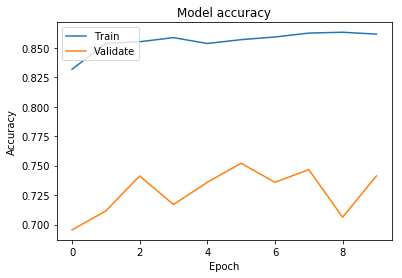

In [23]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
# plt.show()
plt.savefig('acc.png')

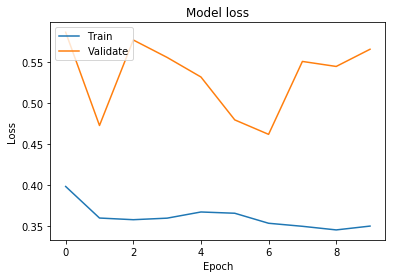

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
# plt.show()
plt.savefig('loss.png')

In [ ]:
model.predict()